In [1]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

In [2]:
file_path = '/kaggle/input/email-classification-ham-spam/email_classification.csv'
df = pd.read_csv(file_path)

df.head(10)

,email,label
0,Upgrade to our premium plan for exclusive acce...,ham
1,Happy holidays from our team! Wishing you joy ...,ham
2,We're hiring! Check out our career opportuniti...,ham
3,Your Amazon account has been locked. Click her...,spam
4,Your opinion matters! Take our survey and help...,ham
5,Your payment has been received. Thank you for ...,ham
6,Your email account storage is full. Click here...,spam
7,"Dear [Name], thank you for subscribing to our ...",ham
8,Your account has been credited with loyalty po...,ham
9,You've been chosen for a free iPhone. Click he...,spam


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   179 non-null    object
 1   label   179 non-null    object
dtypes: object(2)
memory usage: 2.9+ KB


In [4]:
df['label'].value_counts()

label
ham     100
spam     79
Name: count, dtype: int64

In [5]:
def clean_text(text):
    # Видалення небажаних символів
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Залишаємо лише літери латиниці та пробіли
    text = text.lower()  # Перетворення в нижній регістр
    return text

# Очистимо стовпець з текстом
df['email_cleaned'] = df['email'].apply(clean_text)

# Виведемо результат
(df[['email', 'email_cleaned']])

,email,email_cleaned
0,Upgrade to our premium plan for exclusive acce...,upgrade to our premium plan for exclusive acce...
1,Happy holidays from our team! Wishing you joy ...,happy holidays from our team wishing you joy a...
2,We're hiring! Check out our career opportuniti...,were hiring check out our career opportunities...
3,Your Amazon account has been locked. Click her...,your amazon account has been locked click here...
4,Your opinion matters! Take our survey and help...,your opinion matters take our survey and help ...
...,...,...
174,We're pleased to inform you that your refund h...,were pleased to inform you that your refund ha...
175,Get rich quick! Invest in our revolutionary ne...,get rich quick invest in our revolutionary new...
176,Your free trial period is ending soon. Upgrade...,your free trial period is ending soon upgrade ...
177,Your order is on its way! Track your shipment ...,your order is on its way track your shipment f...


In [6]:
# Перетворюємо мітки на числові значення (ham = 0, spam = 1)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Параметри
max_words = 1000  # Максимальна кількість слів для токенізації
max_text_len = 50  # Максимальна довжина тексту (послідовність)

# Токенізація
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['email_cleaned'])
sequences = tokenizer.texts_to_sequences(df['email_cleaned'])

# Паддінг (всі послідовності будуть мати однакову довжину)
X = pad_sequences(sequences, maxlen=max_text_len)

# Мітки
Y = np.array(df['label'])

In [7]:
# Розділяємо на тренувальні та тестові дані
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Визначаємо ваги класів для зменшення дисбалансу
class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [8]:
from keras.callbacks import EarlyStopping

# Побудова моделі
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_text_len))  # Векторизація слів
model.add(LSTM(128, return_sequences=False))  # Рекурентний шар LSTM
model.add(Dense(64, activation='relu'))  # Повнозв'язковий шар
model.add(Dense(1, activation='sigmoid'))  # Вихідний шар для бінарної класифікації

# Компіляція моделі
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Додавання механізму ранньої зупинки
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Навчання моделі з ранньою зупинкою
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_test, Y_test), callbacks=[early_stopping])

# Підсумки моделі
model.summary()

# Оцінка моделі
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Прогнозування
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)  # Перетворюємо ймовірності на класи

# Виведення результатів
print(f"Predicted labels: {predicted_labels.flatten()}")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.6297 - loss: 0.6920 - val_accuracy: 0.7778 - val_loss: 0.6906
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8179 - loss: 0.6889 - val_accuracy: 0.8056 - val_loss: 0.6891
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8015 - loss: 0.6861 - val_accuracy: 0.8056 - val_loss: 0.6873
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8027 - loss: 0.6819 - val_accuracy: 0.7222 - val_loss: 0.6855
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7996 - loss: 0.6779 - val_accuracy: 0.6389 - val_loss: 0.6838
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7722 - loss: 0.6736 - val_accuracy: 0.5833 - val_loss: 0.6815
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7658 - loss: 0.6667 - val_accuracy: 0.5000 - val_loss: 0.6787
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7138 - loss: 0.6588 - val_accuracy: 0.4722 - val_loss:

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 128)        │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,717 (3.07 MB)

 Trainable params: 267,905 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 535,812 (2.04 MB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0024 
Loss: 0.0023766933009028435, Accuracy: 1.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted labels: [1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1]


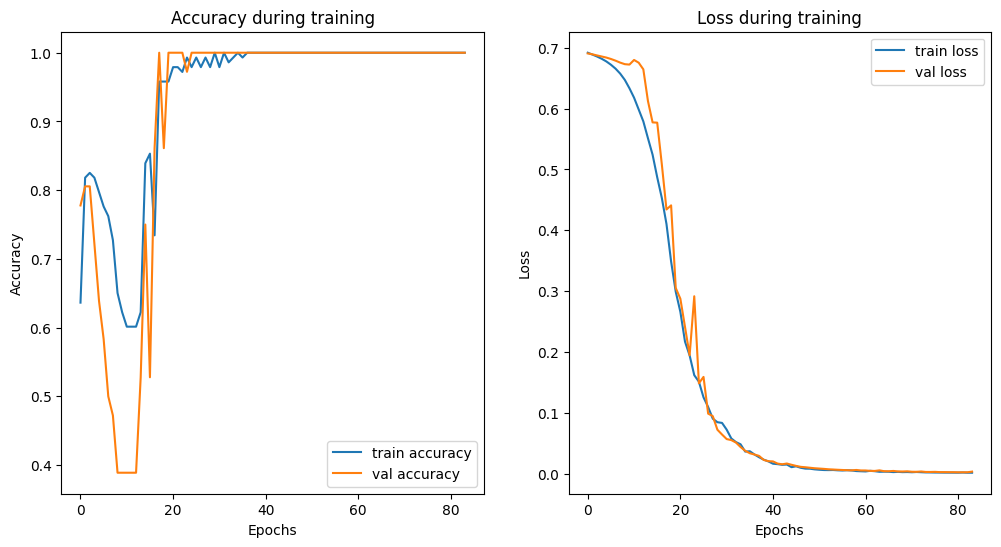

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Графік для accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Графік для loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

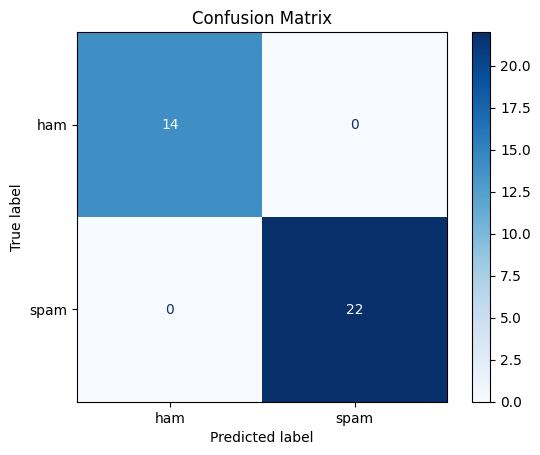

In [10]:
cm = confusion_matrix(Y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Тестування на випадкових 10 повідомленнях
sampled_data = df.sample(n=10, random_state=42)  # Вибірка випадкових 10 повідомлень

# Очищуємо вибрані повідомлення
sampled_data['text_cleaned'] = sampled_data['email'].apply(clean_text)
sampled_sequences = tokenizer.texts_to_sequences(sampled_data['text_cleaned'])
sampled_sequences = pad_sequences(sampled_sequences, padding='post', maxlen=100)

# Передбачення для тестових повідомлень
predictions = model.predict(sampled_sequences)

# Виведення результатів
threshold = 0.7  # Поріг для класифікації
predicted_labels = (predictions > threshold).astype(int)

for i in range(10):
    true_label = 'ham' if sampled_data.iloc[i]['label'] == 0 else 'spam'
    predicted_label = 'ham' if predicted_labels[i] == 0 else 'spam'
    print(f"Message: {sampled_data.iloc[i]['email']}")
    print(f"True label: {true_label}")
    print(f"Predicted probabilities: {predictions[i]}")
    print(f"Predicted label: {predicted_label}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Message: Act now! Limited-time offer on luxury watches. Click here to buy now!
True label: spam
Predicted probabilities: [0.9946538]
Predicted label: spam

Message: You're a winner! Click here to claim your exclusive prize.
True label: spam
Predicted probabilities: [0.99287814]
Predicted label: spam

Message: You've been selected for a free iPhone X. Click here to claim your prize!
True label: spam
Predicted probabilities: [0.9964625]
Predicted label: spam

Message: Get exclusive access to our VIP club. Click here to join now!
True label: spam
Predicted probabilities: [0.9948925]
Predicted label: spam

Message: Claim your prize now! Click here to confirm your winnings.
True label: spam
Predicted probabilities: [0.9915452]
Predicted label: spam

Message: Congratulations! You've been selected for a job interview. Click here to schedule your interview.
True label: spam
Predicted probabilities: [0.9940088]
Predicted label: spam

Message: We're excited

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# 1. Векторизація тексту за допомогою TF-IDF
#Ми використовуємо TfidfVectorizer для перетворення тексту в числову матрицю TF-IDF.
#Можна обмежити кількість характеристик до 5000 для того, щоб уникнути надмірної розмірності.
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['email_cleaned'])  # Перетворення тексту в TF-IDF матрицю

# Мітки
Y = np.array(df['label'])

# 2. Розділення даних на тренувальні та тестові
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 3. Створення і навчання моделі логістичної регресії
#Використовуємо LogisticRegression з параметром max_iter=1000, щоб бути впевненими, що модель буде сходитися.
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)

# 4. Оцінка моделі
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

# Виведення результатів
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{report}')

Accuracy: 0.8611111111111112
Confusion Matrix:
[[14  0]
 [ 5 17]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        14
           1       1.00      0.77      0.87        22

    accuracy                           0.86        36
   macro avg       0.87      0.89      0.86        36
weighted avg       0.90      0.86      0.86        36

